In [288]:
import numpy as np
import math
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import copy


class SAnnealing(object):

    def __init__(self, step = 1, final_temperature=0.1, temperature = 100, alpha=0.95, equilibrium=10, time = 0, capacity = 5, data = []):
        self.step = step
        self.temperature = temperature
        self.final_temperature = final_temperature
        self.alpha = alpha
        self.equilibrium = equilibrium
        self.time = time
        self.capacity = capacity
        self.data = data
        self.best_solution = []
        self.best_cost = 0

    def cost_function(self, f, x):
        return f(self.data, x)

    def getTotalDemand(self):
        totalDemand = 0
        for element in self.data:
            totalDemand += element[2]
        return totalDemand

    def getDemand(self, route):
        demand = 0
        for node in route:
            demand += self.data[node][2]
        return demand

    def create_first_solution(self):
        totalDemand = self.getTotalDemand()
        totalCars = math.ceil(totalDemand / self.capacity)

        while(1):
            routes = []
            for i in np.arange(totalCars):
                routes.append([])
            demands = []

            lista = list(range(1,(len(self.data))))
            random.shuffle(lista)

            for i in np.arange(len(self.data) - 1):
                index = random.randint(0,(totalCars - 1))
                routes[index].append(lista[i])

            for route in routes:
                demands.append(self.getDemand(route))
            
            isUnderDemand = True
            for demand in demands:
                if(demand > self.capacity):
                    isUnderDemand = False

            if(isUnderDemand):
                break

        return routes

    def create_neighbor_solution(self, actual_solution):    
        while(1):
            neighbor = copy.deepcopy(actual_solution)
            idx = random.randint(0,(len(self.data)-2))

            i = 0
            chargedNode = 0
            chargedRoute = 0
            for route in neighbor:
                for node in route:
                    if(i == idx):
                        chargedNode = node
                    i += 1
                if(chargedNode):
                    route.remove(chargedNode)
                    break
                chargedRoute += 1

            idxRoute = random.randint(0,(len(neighbor)-1))
            idxNode = random.randint(0, len(neighbor[idxRoute]))
            neighbor[idxRoute].insert(idxNode, chargedNode)

            demands = []
            for route in neighbor:
                demands.append(self.getDemand(route))

            isUnderDemand = True
            for demand in demands:
                if(demand > self.capacity):
                    isUnderDemand = False
            
            if(isUnderDemand):
                return neighbor

    def aceptance_probability(self, deltaE, temperature):
        try:
            r = math.exp(-deltaE/temperature)
        except OverflowError:
            r = float("inf") 
        return r

    def update_temperature(self, temperature):
        return self.alpha * temperature

    def fit(self, objetive):
        self.cost_ = []
        actual_solution = self.create_first_solution()
        epoch = 0
        number_tested_solution = 0
        aceptanced = 100
        inicio = time.time()
        while (self.temperature > self.final_temperature):
            number_worst_solution_acepted = 0
            i = 0
            while (i < self.equilibrium):
                random_solution = self.create_neighbor_solution(actual_solution)
                number_tested_solution += 1
                delta_E = self.cost_function(objetive, random_solution) - self.cost_function(objetive, actual_solution)
                if delta_E < 0:
                    actual_solution = random_solution.copy()
                else:
                    deg_deltaE = self.aceptance_probability(delta_E, self.temperature)
                    if(np.random.uniform(0, 1) < deg_deltaE):
                        actual_solution = random_solution.copy()
                        number_worst_solution_acepted += 1
                x = self.cost_function(objetive, actual_solution)
                self.cost_.append((x,1))
                epoch_strlen = len(str(epoch))
                fin = time.time()
                total = fin - inicio
                sys.stderr.write('\r%0*d Epoch | Equilibrium %d | Temperature %.2f '
                                '| Actual solution %f | Aceptance : %.2f | Time: %f' 
                        %
                        (epoch_strlen, epoch+1, i+1, self.temperature, 
                        x,aceptanced, total))
                time.sleep(self.time)
                sys.stderr.flush()
                i += 1
                epoch += 1
            aceptanced = number_worst_solution_acepted * 100 /number_tested_solution
            self.temperature = self.update_temperature(self.temperature)
        self.best_solution = actual_solution
        self.best_cost = x
        print(f'There are the best routes: {actual_solution}')

In [289]:
def CVRP_function(routes):
    distance = 0
    for i in np.arange(len(routes)-1):
        distance += np.sqrt((routes[i][0] - routes[i+1][0])**2 + (routes[i][1] - routes[i+1][1])**2)
    return distance

def getAllDistances(data, routes):
    allDistances = 0
    for route in routes:
        coordenates = []
        coordenates.append(data[0][1])
        for node in route:
            coordenates.append(data[node][1])
        coordenates.append(data[0][1])
        allDistances += CVRP_function(coordenates)
    return allDistances

In [290]:
def drawRoutes(data, routes):
    plt.rcParams["figure.figsize"] = [7.50, 5.50]
    plt.rcParams["figure.autolayout"] = True

    x = []
    y = []
    demand = []

    for i in range (0, len(data)):
        x.append(data[i][1][0])
        y.append(data[i][1][1])
        demand.append(data[i][2])

    plt.scatter(x, y)

    colors = ['b', 'g', 'r', 'c', 'm', 'y']

    idxColor = 0
    for route in routes:
        plt.plot((x[0], x[route[0]]),(y[0], y[route[0]]), c=colors[idxColor % len(colors)])
        for i in np.arange(len(route)-1):
            plt.plot((x[route[i]], x[route[i+1]]),(y[route[i]], y[route[i+1]]), c=colors[idxColor % len(colors)])
        try:
            plt.plot((x[0], x[route[i+1]]),(y[0], y[route[i+1]]), c=colors[idxColor % len(colors)])
        except:
            None
        idxColor += 1

    i = 0

    for xy in zip(x, y):
        plt.annotate((str(i), demand[i]), xy=xy, )
        i += 1

    plt.plot(x[0], y[0], 'ro', c="r", ms=15)

    plt.grid()
    plt.show()

In [295]:
def getData(lenData):
    data = []
    for i in np.arange(lenData):
        data.append([])
        data[i].append(-1)
        data[i].append([-1,-1])
        data[i].append(-1)
    
    return data

def convertListCharToString(listChar):
    new = ""
    for x in listChar:
        new += x
    return new
     
def getCVRPFileData(namePath):
    with open(namePath) as f:
        file = f.readlines()

    string = convertListCharToString(file)

    stringDimensions = "DIMENSION : "
    dimensionsIndex  = string.find(stringDimensions) + len(stringDimensions)
    dimension = ""

    while(string[dimensionsIndex] != '\n'):
        dimension += string[dimensionsIndex]
        dimensionsIndex += 1

    dimension = int(dimension)
    data = getData(dimension)
    stringCord = "NODE_COORD_SECTION" 
    initialIndex = string.find(stringCord) + len(stringCord) + 2
    indicator = 0

    i = 0
    while(string[initialIndex] != 'D'):
        number = ""
        while(ord(string[initialIndex]) != 32 and string[initialIndex] != '\n'):
            number += string[initialIndex]
            initialIndex += 1
        if(len(number) > 0):        
            if indicator == 0:
                data[i][0] = (int(number) - 1)
                indicator += 1
            elif indicator == 1:
                data[i][1][0] = int(number)
                indicator += 1      
            elif indicator == 2:
                data[i][1][1] = int(number)
                indicator = 0
                i += 1
        initialIndex +=1

    stringCost = "DEMAND_SECTION"
    initialIndex = string.find(stringCost) + len(stringCost) + 2
    indicator = 0
    i = 0
    while(string[initialIndex] != 'D'):
        number = ""
        while(ord(string[initialIndex]) != 32 and string[initialIndex] != '\n'):
            number += string[initialIndex]
            initialIndex += 1
        if(len(number) > 0):        
            if indicator == 0:
                indicator += 1
            elif indicator == 1:
                data[i][2] = int(number)
                indicator = 0     
                i += 1
        initialIndex +=1
    
    stringCapacity = "CAPACITY : "
    initialIndex = string.find(stringCapacity) + len(stringCapacity)
    capacity = ""
    while(string[initialIndex] != '\n'):
        capacity += string[initialIndex]
        initialIndex += 1

    return data, int(capacity)

In [356]:
data, capacity = getCVRPFileData('./A-n33-k5.txt')
sa = SAnnealing(step=0.01, final_temperature=0.001, temperature=100000, alpha=0.95, equilibrium=30, time=0, capacity=capacity, data = data)
sa.fit(getAllDistances)

10800 Epoch | Equilibrium 30 | Temperature 0.00 | Actual solution 680.594926 | Aceptance : 0.04 | Time: 23.9810214106

There are the best routes: [[29, 16, 3, 9, 17, 10], [23, 18, 28, 15, 22], [2, 32, 13, 26, 7, 8, 20], [4, 5, 27, 25, 30, 12], [24, 6, 19, 14, 21, 1, 31, 11]]


/var/folders/yv/xlbmlrh90c7bcl6zn1k7n12w0000gn/T/ipykernel_26490/4290274030.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x[0], y[0], 'ro', c="r", ms=15)


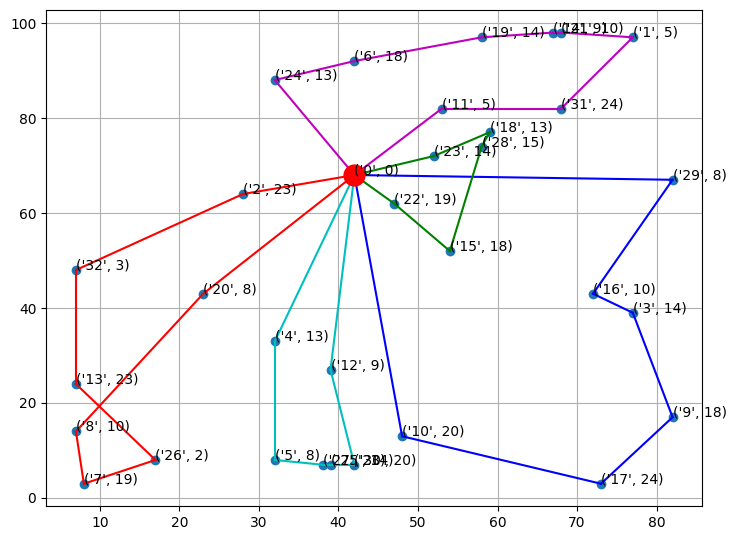

In [357]:
drawRoutes(data, sa.best_solution)

In [ ]:
plt.plot(range(len(sa.cost_)), [x[0] for x in sa.cost_ ])
plt.show()

1670 Epoch | Equilibrium 10 | Temperature 0.10 | Actual solution 265.253776 | Aceptance : 0.12 | Time: 2.49167400/var/folders/yv/xlbmlrh90c7bcl6zn1k7n12w0000gn/T/ipykernel_26490/4290274030.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x[0], y[0], 'ro', c="r", ms=15)


There are the best routes: [[4, 1], [5, 2, 3]]


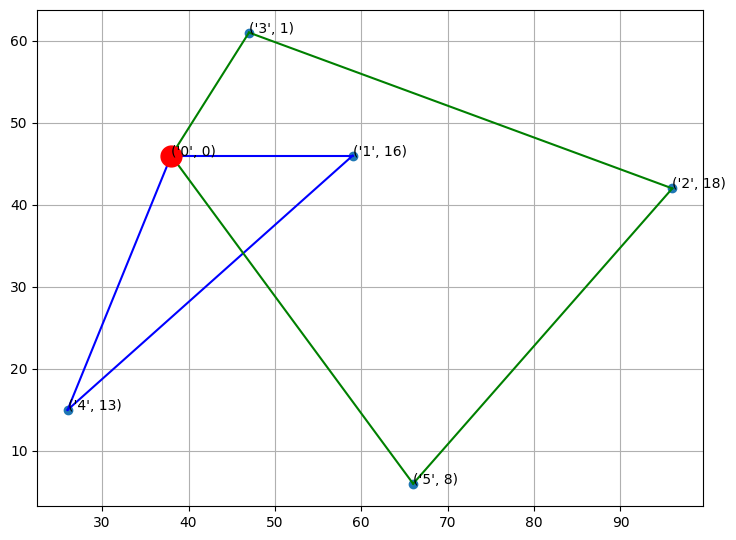

In [300]:
data = [[0,[38,46],0], [1,[59,46],16], [2,[96,42],18], [3,[47,61],1], [4,[26,15],13], [5,[66,6],8]]

sa = SAnnealing(step=1, final_temperature=0.1, temperature=500, alpha=0.95, equilibrium=10, time=0, capacity = 30, data = data)
sa.fit(getAllDistances)

drawRoutes(data, sa.best_solution)

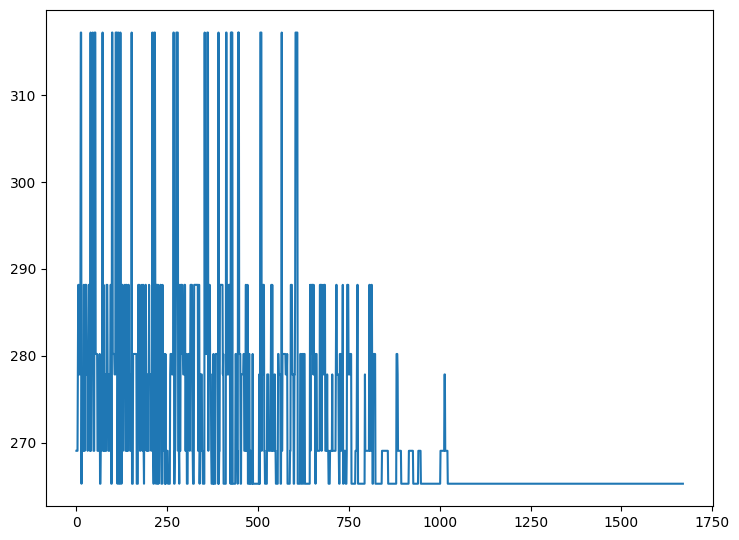

In [301]:
plt.plot(range(len(sa.cost_)), [x[0] for x in sa.cost_ ])
plt.show()